In [ ]:
%load_ext autoreload
%autoreload 2
    
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from pyleoclim.utils import spectral

In [2]:
def gen_noise(alpha, t, f0=None, m=None):
    ''' Generate a colored noise timeseries

    Args:
        alpha (float): exponent of the 1/f^alpha noise
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the highest frequency of the components in the synthetic noise

    Returns:
        y (array): the generated 1/f^alpha noise

    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies. Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n

    k = np.arange(m) + 1  # wave numbers

    theta = np.random.rand(int(m))*2*np.pi  # random phase
    for j in range(n):
        coeff = (k*f0)**(-alpha/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y

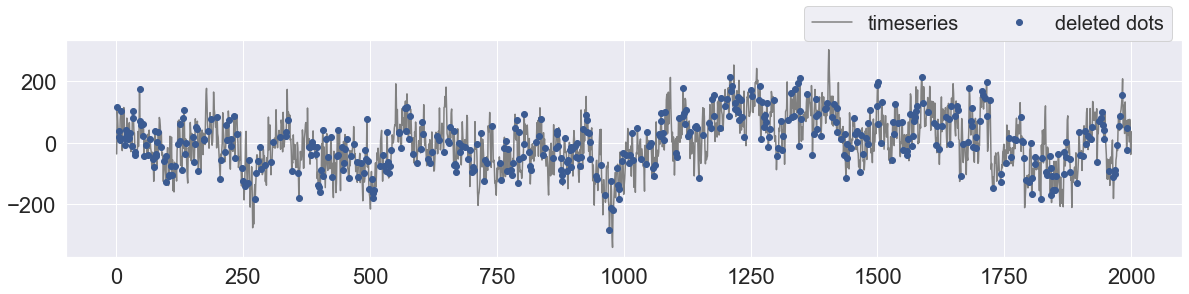

In [3]:
np.random.seed(2333)

to_evenly = np.arange(1, 2001)
Xo_evenly = gen_noise(1, to_evenly, m=np.size(to_evenly)/2)  # set such m so that no aliasing occurs

n_del = 500  # delete 500 pts from 2000 pts
deleted_idx = np.random.choice(range(np.size(to_evenly)), n_del, replace=False)

to_unevenly =  np.delete(to_evenly, deleted_idx)
Xo_unevenly =  np.delete(Xo_evenly, deleted_idx)

sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_evenly, Xo_evenly, color='gray', label='timeseries')
plt.plot(to_evenly[deleted_idx], Xo_evenly[deleted_idx], 'o', color=sns.xkcd_rgb['denim blue'], label='deleted dots')
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.2), loc='upper right', ncol=3)

In [4]:
freqs = None
tau_evenly = np.linspace(np.min(to_evenly), np.max(to_evenly), 101)
tau_unevenly = np.linspace(np.min(to_unevenly), np.max(to_unevenly), 101)
dcon = 1e-3

In [9]:
%%time
res_psd_python = Spectral.wwz_psd(Xo_evenly, to_evenly, freqs=freqs, tau=tau_evenly, c=dcon, standardize=False, nMC=0, anti_alias=False,
                                method='Kirchner', nproc=1)

CPU times: user 21.1 s, sys: 9.29 ms, total: 21.1 s
Wall time: 21.2 s


In [10]:
%%time
res_psd_nproc = Spectral.wwz_psd(Xo_evenly, to_evenly, freqs=freqs, tau=tau_evenly, c=dcon, standardize=False, nMC=0, anti_alias=False,
                                method='Kirchner', nproc=16)

CPU times: user 4.91 s, sys: 136 ms, total: 5.04 s
Wall time: 5.45 s


In [11]:
%%time
res_psd_numba = Spectral.wwz_psd(Xo_evenly, to_evenly, freqs=freqs, tau=tau_evenly, c=dcon, standardize=False, nMC=0, anti_alias=False,
                                method='Kirchner_numba')

CPU times: user 6.15 s, sys: 76.5 ms, total: 6.22 s
Wall time: 3.18 s


In [18]:
%%time
res_psd_f2py = Spectral.wwz_psd(Xo_evenly, to_evenly, freqs=freqs, tau=tau_evenly, c=dcon, standardize=False, nMC=0, anti_alias=False)

CPU times: user 12.9 s, sys: 9.48 ms, total: 13 s
Wall time: 1.86 s


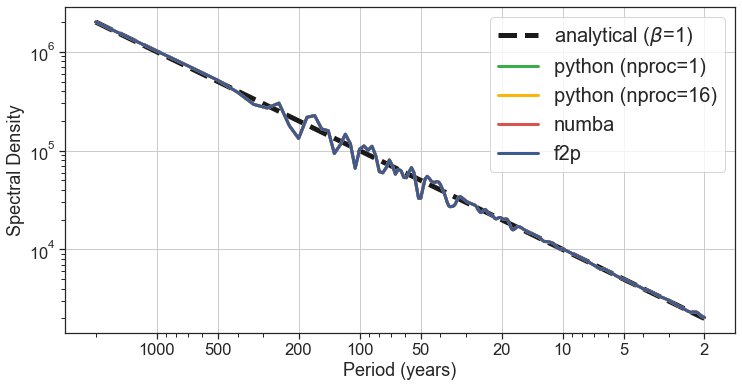

In [20]:
period_ticks = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
psd_ideal_ref = 0.5*res_psd_python.freqs**(-1)/(1/np.size(to_evenly))

fig = Spectral.plot_psd(psd_ideal_ref, res_psd_python.freqs, plot_ar1=False, psd_ar1_q95=None, period_ticks=period_ticks, lmstyle='--', color='k', label=r'analytical ($\beta$=1)', figsize=[12, 6], linewidth=5)
plt.plot(1/res_psd_python.freqs, res_psd_python.psd, '-', linewidth=3, label=r'python (nproc=1)', color=sns.xkcd_rgb['medium green'])
plt.plot(1/res_psd_nproc.freqs, res_psd_nproc.psd, '-', linewidth=3, label=r'python (nproc=16)', color=sns.xkcd_rgb['amber'])
plt.plot(1/res_psd_numba.freqs, res_psd_numba.psd, '-', linewidth=3, label=r'numba', color=sns.xkcd_rgb['pale red'])
plt.plot(1/res_psd_f2py.freqs, res_psd_f2py.psd, '-', linewidth=3, label=r'f2p', color=sns.xkcd_rgb['denim blue'])

plt.legend(fontsize=20, bbox_to_anchor=(1, 1), loc='upper right', ncol=1)